# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import numpy as np
import math
import json
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Explore Data:

**count number rows and columns**

In [2]:
profile.shape

(17000, 5)

In [3]:
portfolio.shape

(10, 6)

In [4]:
transcript.shape

(306534, 4)

**Display 5 rows from the files**

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


**Discribe the files**

In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [10]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


**Display the information from the files**

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [13]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**Count number of missing values**

In [14]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [16]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [17]:
profile.age.max(),profile.age.min()

(118, 18)

In [18]:
profile.income.max(),profile.income.min()

(120000.0, 30000.0)

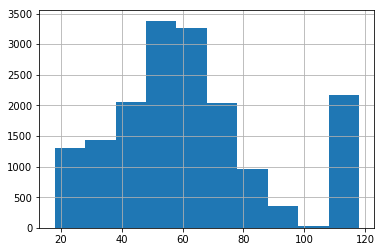

In [19]:
profile.age.hist()

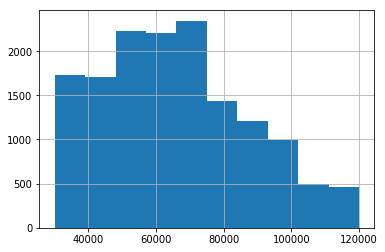

In [20]:
profile.income.hist()

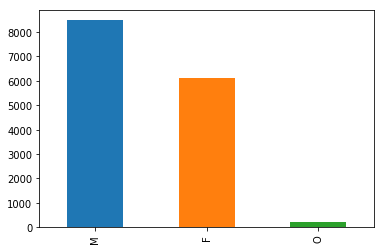

In [21]:
profile.gender.value_counts().plot.bar()

### Cleaning data:

#### profile data:

**In profile data we have gender and income features that have some missing value, so we have to approachs to deal with this, Drop any row that contain a missing value, or take a value by a mode or median for examble and fil the missing values.We will take the first approach, because we have 2175 missing values only (12% from all the data only)**

In [22]:
profile.dropna(inplace=True)
profile.shape

(14825, 5)

In [23]:
# Reanme id to customer_id
profile.rename(columns={'id':'customer_id'},inplace=True)

In [24]:
# convert the type of became_member_on column to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [25]:
profile.tail()

,age,became_member_on,gender,customer_id,income
16995,45,2018-06-04,F,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0
16996,61,2018-07-13,M,2cb4f97358b841b9a9773a7aa05a9d77,72000.0
16997,49,2017-01-26,M,01d26f638c274aa0b965d24cefe3183f,73000.0
16998,83,2016-03-07,F,9dc1421481194dcd9400aec7c9ae6366,50000.0
16999,62,2017-07-22,F,e4052622e5ba45a8b96b59aba68cf068,82000.0


#### Portfolio data:

In [26]:
# Reanme id to offer_id
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [27]:
d = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
# concatenating  'portfolio' df  df with dummy
portfolio = pd.concat([portfolio, d], axis=1)
# Remove the original column
portfolio = portfolio.drop(columns='channels')

In [28]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


#### transcript data:

In [29]:
transcript.tail()

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [30]:
transcript = pd.concat([transcript, pd.get_dummies(transcript['event'])], axis=1 )

In [31]:
transcript.rename(columns={'value':'v'},inplace=True)

In [32]:
def cleaning_transcript():
    """
    This method will clean the transcript 
    
    
    Parameters:
    void
    
    Returns:
    void
    """
    transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.v]
    transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.v]
    transcript.drop(columns='v',inplace=True)

In [33]:
cleaning_transcript();

In [34]:
transcript.head()

,event,person,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [35]:
transcript['event'] = transcript['event'].str.replace(' ', '-')

In [36]:
# rename the column
transcript.rename(columns={'person':'customer_id'},inplace=True)


In [37]:
transcript.tail(10)

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,0,0,0,1,None,25.14
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,0,0,0,1,None,43.58
306526,transaction,24f56b5e1849462093931b164eb803b5,714,0,0,0,1,None,22.64
306527,offer-completed,24f56b5e1849462093931b164eb803b5,714,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
306528,transaction,5ca2620962114246ab218fc648eb3934,714,0,0,0,1,None,2.20
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,0,0,0,1,None,1.59
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,0,0,0,1,None,9.53
306531,transaction,a00058cf10334a308c68e7631c529907,714,0,0,0,1,None,3.61
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,0,0,0,1,None,3.53
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,0,0,0,1,None,4.05


In [38]:
# merge tha data sets
df = pd.merge(transcript, profile, on='customer_id')

In [39]:
# merge tha data sets
df = pd.merge(df, portfolio, on='offer_id')

In [40]:
df.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,age,...,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,F,100000.0,5,7,bogo,5,1,1,0,1
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,F,100000.0,5,7,bogo,5,1,1,0,1
2,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,F,100000.0,5,7,bogo,5,1,1,0,1
3,offer-received,e2127556f4f64592b11af22de27a7932,408,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,...,M,70000.0,5,7,bogo,5,1,1,0,1
4,offer-viewed,e2127556f4f64592b11af22de27a7932,420,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,...,M,70000.0,5,7,bogo,5,1,1,0,1


In [41]:
coded_dict = dict()  
c = 1
ids = []

for v in df['customer_id']:
    if v not in coded_dict:
        coded_dict[v] = c
        c+=1

    ids.append(coded_dict[v])
del df['customer_id']
df['customer_id'] = ids

In [42]:
coded_dict = dict()  
c = 1
ids = []

for v in df['offer_id']:
    if v not in coded_dict:
        coded_dict[v] = c
        c+=1

    ids.append(coded_dict[v])
del df['offer_id']
df['offer_id'] = ids

In [43]:
df[df.customer_id == 1]

,event,time,offer completed,offer received,offer viewed,transaction,amount,age,became_member_on,gender,...,difficulty,duration,offer_type,reward,email,mobile,social,web,customer_id,offer_id
0,offer-received,0,0,1,0,0,NaN,75,2017-05-09,F,...,5,7,bogo,5,1,1,0,1,1,1
1,offer-viewed,6,0,0,1,0,NaN,75,2017-05-09,F,...,5,7,bogo,5,1,1,0,1,1,1
2,offer-completed,132,1,0,0,0,NaN,75,2017-05-09,F,...,5,7,bogo,5,1,1,0,1,1,1
14372,offer-received,168,0,1,0,0,NaN,75,2017-05-09,F,...,0,3,informational,0,1,1,1,0,1,2
14373,offer-viewed,216,0,0,1,0,NaN,75,2017-05-09,F,...,0,3,informational,0,1,1,1,0,1,2
26888,offer-received,408,0,1,0,0,NaN,75,2017-05-09,F,...,10,7,bogo,10,1,1,1,0,1,3
26889,offer-viewed,408,0,0,1,0,NaN,75,2017-05-09,F,...,10,7,bogo,10,1,1,1,0,1,3
26890,offer-completed,510,1,0,0,0,NaN,75,2017-05-09,F,...,10,7,bogo,10,1,1,1,0,1,3
43129,offer-received,504,0,1,0,0,NaN,75,2017-05-09,F,...,5,5,bogo,5,1,1,1,1,1,4
43130,offer-completed,510,1,0,0,0,NaN,75,2017-05-09,F,...,5,5,bogo,5,1,1,1,1,1,4


### Data Visualization

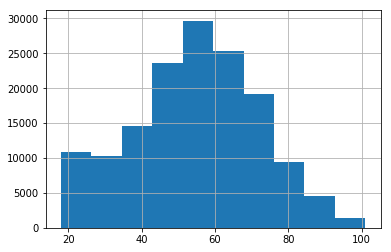

In [44]:
df.age.hist()

we see her most of users age between 40 - 70

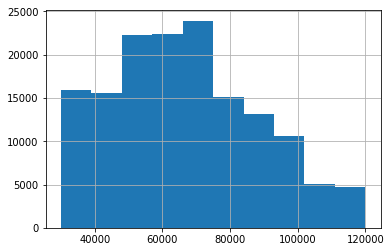

In [45]:
df.income.hist()

we see her most of users income between 20000 - 25000

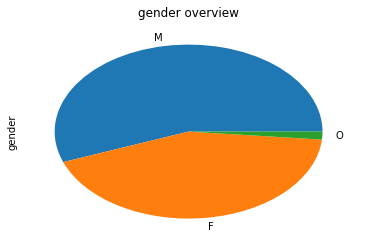

In [46]:
df.gender.value_counts().plot(kind='pie' ,title="gender overview")

we see her most of users gender are meale or feamle

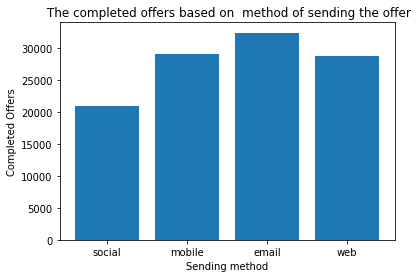

In [47]:
a =  df[(df['offer completed'] == 1) & (df['social'] == 1)].shape[0]
b =  df[(df['offer completed'] == 1) & (df['mobile'] == 1)].shape[0]
c =  df[(df['offer completed'] == 1) & (df['email'] == 1)].shape[0]
d =  df[(df['offer completed'] == 1) & (df['web'] == 1)].shape[0]
labels = ['social', 'mobile', 'email', 'web']
plt.bar([1,2,3,4], [a,b,c,d], tick_label = labels)
plt.title(' The completed offers based on  method of sending the offer')
plt.xlabel('Sending method')
plt.ylabel('Completed Offers');

we see 'email'  method offer is most likely to be completed than 'social','mobile','web'.

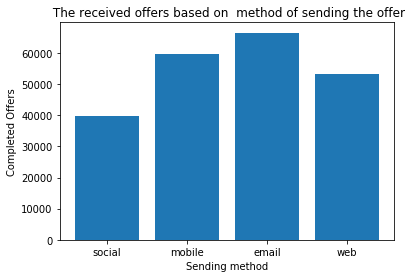

In [48]:
a =  df[(df['offer received'] == 1) & (df['social'] == 1)].shape[0]
b =  df[(df['offer received'] == 1) & (df['mobile'] == 1)].shape[0]
c =  df[(df['offer received'] == 1) & (df['email'] == 1)].shape[0]
d =  df[(df['offer received'] == 1) & (df['web'] == 1)].shape[0]
labels = ['social', 'mobile', 'email', 'web']
plt.bar([1,2,3,4], [a,b,c,d], tick_label = labels)
plt.title(' The received offers based on  method of sending the offer')
plt.xlabel('Sending method')
plt.ylabel('Completed Offers');

we see 'email'  method offer is most likely to be recived than 'social','mobile','web'.

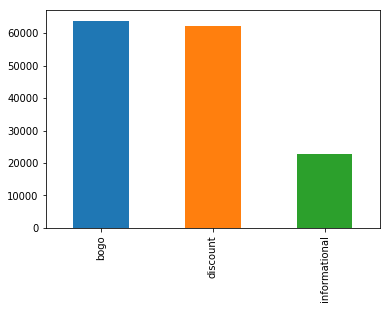

In [49]:
df.offer_type.value_counts().plot.bar()

we see the offer type usually be bogo or discount

## Modeling:

In [50]:
# convert string columns to int columns for modeling
df['offer_type'] = df['offer_type'].map({'bogo': 1, 'discount': 2, 'informational': 3})
df['gender'] = df['gender'].map({'M': 1, 'F': 2, 'O': 3})
df['event_id'] = df['event'].map({'offer-completed': 1, 'offer-received': 2, 'offer-viewed': 3})
df=df.fillna(0)

In [51]:
df.head()

,event,time,offer completed,offer received,offer viewed,transaction,amount,age,became_member_on,gender,...,duration,offer_type,reward,email,mobile,social,web,customer_id,offer_id,event_id
0,offer-received,0,0,1,0,0,0.0,75,2017-05-09,2,...,7,1,5,1,1,0,1,1,1,2
1,offer-viewed,6,0,0,1,0,0.0,75,2017-05-09,2,...,7,1,5,1,1,0,1,1,1,3
2,offer-completed,132,1,0,0,0,0.0,75,2017-05-09,2,...,7,1,5,1,1,0,1,1,1,1
3,offer-received,408,0,1,0,0,0.0,68,2018-04-26,1,...,7,1,5,1,1,0,1,2,1,2
4,offer-viewed,420,0,0,1,0,0.0,68,2018-04-26,1,...,7,1,5,1,1,0,1,2,1,3


In [52]:
Y = df.event_id
X = df.drop(['event','reward','transaction','offer completed', 'offer viewed',
                 'became_member_on', 'offer_id', 'customer_id','event_id'], axis = 1)

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [54]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
model.score(X_valid, y_valid)
print(f"Accuracy Of Training: {model.score(X_train, y_train)} \nAccuracy Of testing::  {model.score(X_valid, y_valid)}")

Accuracy Of Training: 0.07244868802579096 
Accuracy Of testing::  0.0720517079847669


In [56]:
Y = df.event_id
X = df.drop(['event','reward','transaction','offer completed', 'offer viewed',
                 'became_member_on', 'offer_id', 'customer_id','event_id'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predicted_train = clf.predict(X_train)
predicted_test = clf.predict(X_test)

score_of_train = accuracy_score(y_train, predicted_train)
score_of_test = accuracy_score(y_test, predicted_test)

print('Accuracy Of Training: ' , score_of_train)
print('Accuracy Of Testing: ', score_of_test)

## Conclusion

wee see here the RandomForestClassifier is better than LinearRegression

## References
https://pandas.pydata.org/
https://matplotlib.org/
https://www.udacity.com/

In [ ]:
!tar chvfz notebook.tar.gz *